In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("all_indices_data.csv")

# Preview the data
df.head()

,date,open,high,low,close,volume,ticker
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.0,^GSPC
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.0,^GSPC
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.0,^GSPC
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.0,^GSPC
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.0,^GSPC


In [3]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])


In [6]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

# Check for suspicious zero volume on non-holidays
zero_volume = df[df['volume'] == 0]
print("Zero volume records:", len(zero_volume))


Missing values:
 date      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64
Duplicate rows: 0
Zero volume records: 113751


In [7]:
zero_volume_by_ticker = df[df['volume'] == 0]['ticker'].value_counts()
zero_volume_by_ticker.head(10)


ticker
^N225        9237
^NYA         8828
^VIX         8685
^MERV        6777
^AXJO        6238
^GSPC        5496
^AORD        4721
^IPSA        4346
^BFX         4083
^TA125.TA    3919
Name: count, dtype: int64

## 1. Zero Volume Records Analysis

- There are **113,751** records in the dataset with zero trading volume.
- These zero-volume records are distributed across multiple major tickers such as:
  - Nikkei 225 (^N225): 9,237 zero-volume records
  - NYSE Composite (^NYA): 8,828 zero-volume records
  - Volatility Index (^VIX): 8,685 zero-volume records
  - S&P 500 (^GSPC): 5,496 zero-volume records
- Many of these tickers represent **market indices or volatility measures**, which often do not have traditional volume data.
- The presence of zero volume on trading days for these tickers suggests either:
  - Missing volume data in the feed, or
  - Volume is not applicable to these instruments.

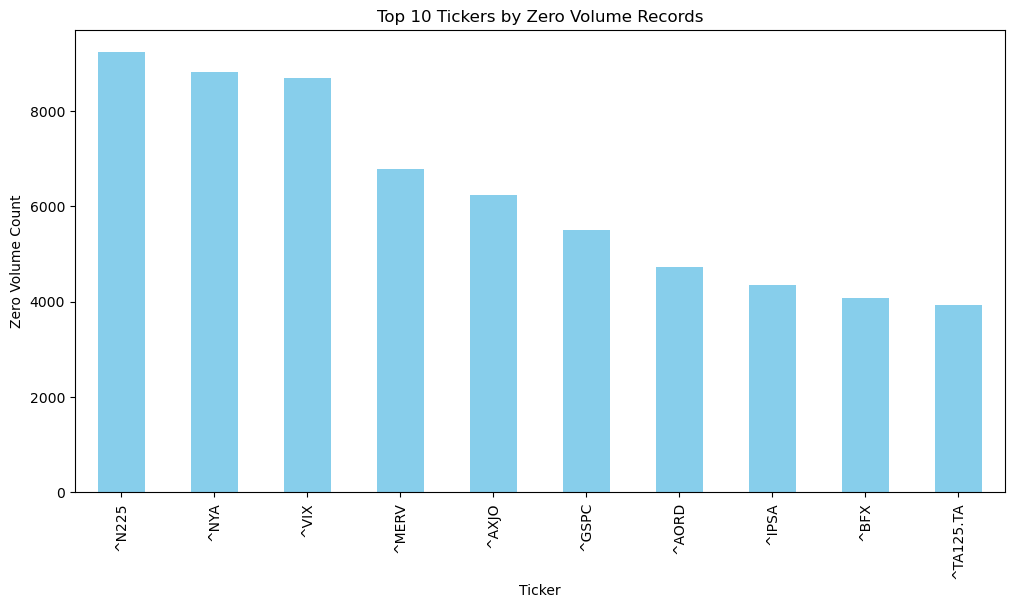

In [9]:


zero_volume_counts = df[df['volume'] == 0]['ticker'].value_counts().head(10)

plt.figure(figsize=(12,6))
zero_volume_counts.plot(kind='bar', color='skyblue')
plt.title("Top 10 Tickers by Zero Volume Records")
plt.xlabel("Ticker")
plt.ylabel("Zero Volume Count")
plt.show()


In [8]:
df['weekday'] = df['date'].dt.day_name()

zero_vol_days = df[df['volume'] == 0]
zero_vol_days['weekday'].value_counts()


weekday
Wednesday    23314
Tuesday      23279
Thursday     23083
Monday       22149
Friday       21886
Sunday          40
Name: count, dtype: int64

## 2. Weekday Distribution of Zero Volume Records

- Surprisingly, the majority of zero-volume records fall on **weekdays**, which are normal trading days:
  - Wednesday (23,314)
  - Tuesday (23,279)
  - Thursday (23,083)
  - Monday (22,149)
  - Friday (21,886)
- Only a few zero-volume records fall on weekends (Sunday: 40), when markets are closed.
- This indicates potential data integrity issues, since zero volume on active trading days is unusual.
- It’s important to differentiate between genuine non-trading days and missing data.

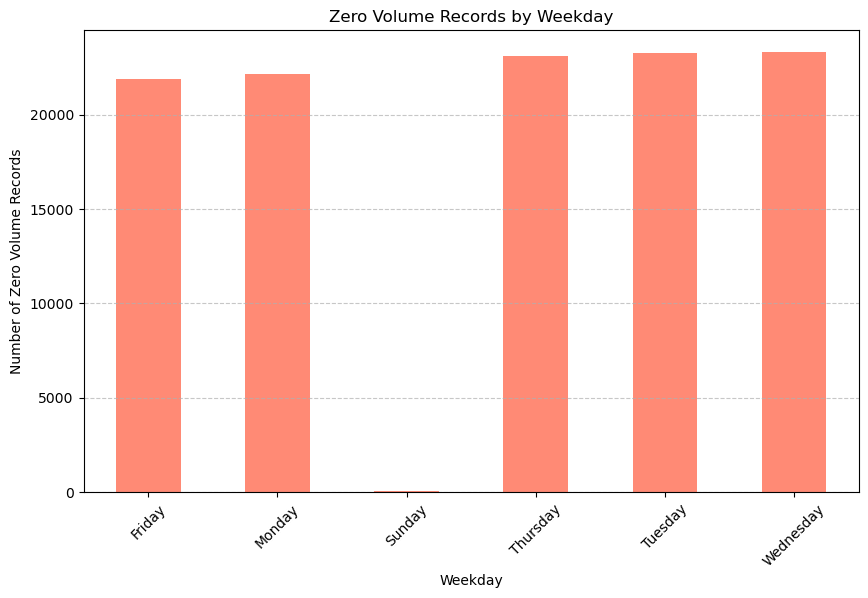

In [10]:
zero_volume_weekday_counts = zero_vol_days['weekday'].value_counts().sort_index()

plt.figure(figsize=(10,6))
zero_volume_weekday_counts.plot(kind='bar', color='tomato', alpha=0.75)

plt.title("Zero Volume Records by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Zero Volume Records")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [11]:
# Price change on zero-volume days
df['pct_change'] = df['close'].pct_change()
zero_vol_price_change = df[df['volume'] == 0]['pct_change'].abs().mean()

# Price change on non-zero-volume days
nonzero_vol_price_change = df[df['volume'] > 0]['pct_change'].abs().mean()

print("Avg. price change on zero-volume days:", zero_vol_price_change)
print("Avg. price change on non-zero-volume days:", nonzero_vol_price_change)


Avg. price change on zero-volume days: 0.013357661670864033
Avg. price change on non-zero-volume days: 0.008400253092899131


## 3. Price Change Behavior on Zero vs Non-Zero Volume Days

- The average daily price change on zero-volume days is **~1.34%**, which is higher than the **~0.84%** average on non-zero volume days.
- This suggests that zero volume days still experience significant price fluctuations.
- Likely explanation:
  - For indices or certain instruments, volume data may not be recorded, but price calculations still occur.
  - Zero volume does not always indicate market inactivity.
- Clients relying solely on volume data should be cautious about interpreting zero volume as no market activity.


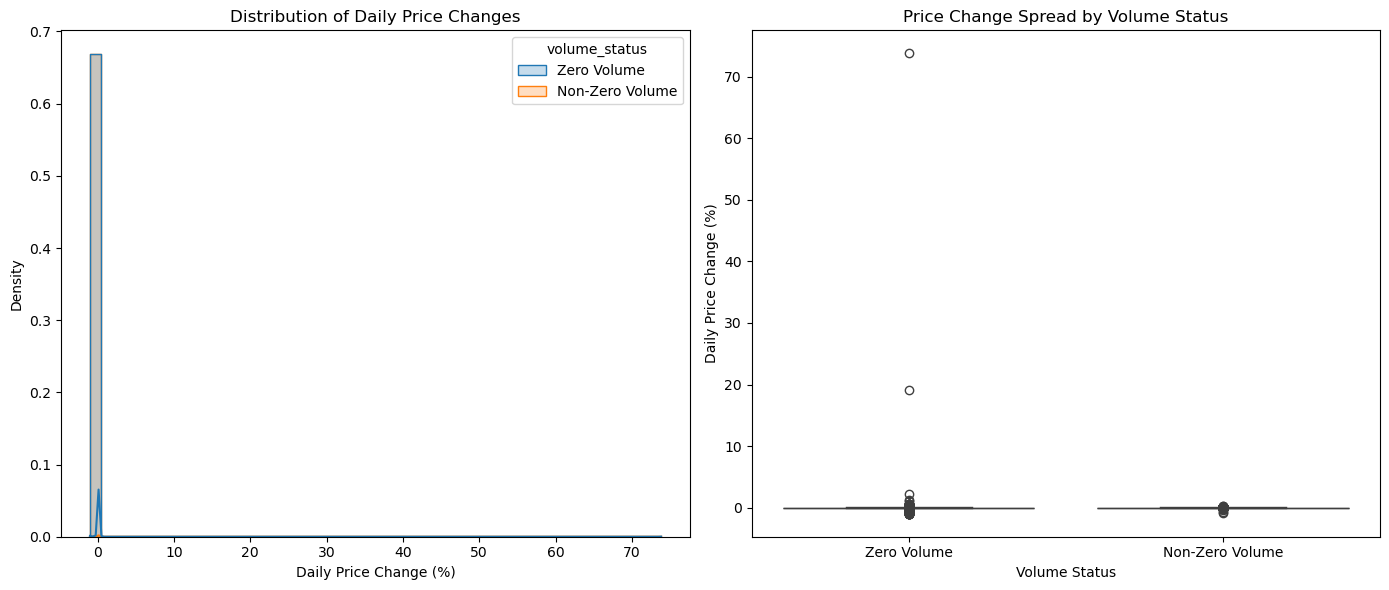

In [13]:
import seaborn as sns
# Create a new column to categorize zero vs non-zero volume days
df['volume_status'] = df['volume'].apply(lambda x: 'Zero Volume' if x == 0 else 'Non-Zero Volume')

plt.figure(figsize=(14,6))

# Histogram of price changes by volume status
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='pct_change', hue='volume_status', bins=50, kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Daily Price Changes')
plt.xlabel('Daily Price Change (%)')
plt.ylabel('Density')

# Boxplot of price changes by volume status
plt.subplot(1, 2, 2)
sns.boxplot(x='volume_status', y='pct_change', data=df)
plt.title('Price Change Spread by Volume Status')
plt.ylabel('Daily Price Change (%)')
plt.xlabel('Volume Status')

plt.tight_layout()
plt.show()